In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import os
import time
import sys
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
train_file = './data/train.csv'
eval_file = './data/eval.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

In [3]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [4]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


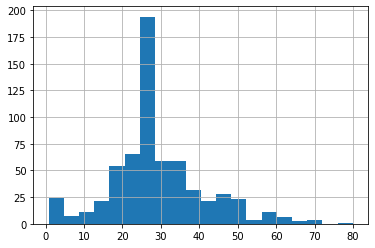

In [6]:
train_df.age.hist(bins = 20)

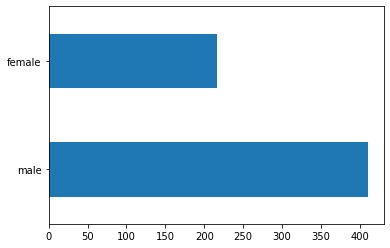

In [7]:
train_df.sex.value_counts().plot(kind = 'barh')

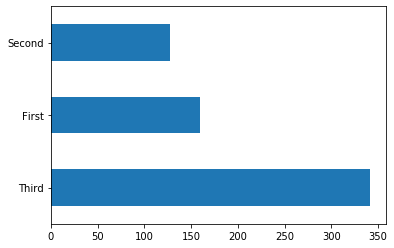

In [8]:
train_df['class'].value_counts().plot(kind = 'barh')

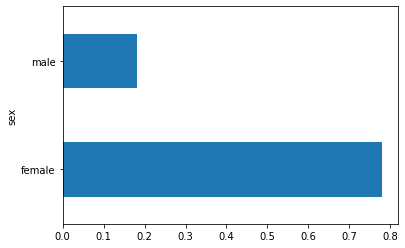

In [9]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

In [11]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                      'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []

for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column, dtype=tf.float32))

# cross features: age:[1,2,3,4,5], gender:[male, female]
# age_x_gender:[(1, male), (2, male),...,(1, female), (2, female)]
feature_columns.append(
    tf.feature_column.indicator_column(
        tf.feature_column.crossed_column(['age', 'sex'],
                                  hash_bucket_size=100)))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [12]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [13]:
output_dir = 'baseline_model_new_features'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

baseline_estimator = tf.estimator.BaselineClassifier(
    model_dir=output_dir,
    n_classes=2)
baseline_estimator.train(input_fn=lambda : make_dataset(train_df, y_train, epochs =100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'baseline_model_new_features', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13f486f50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *

FailedPreconditionError: GetNext() failed because the iterator has not been initialized. Ensure that you have run the initializer operation for this iterator before getting the next element.
	 [[node IteratorGetNext (defined at /Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]

Original stack trace for 'IteratorGetNext':
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cf22d4cd765c>", line 8, in <module>
    baseline_estimator.train(input_fn=lambda : make_dataset(train_df, y_train, epochs =100))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 370, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1160, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1187, in _train_model_default
    input_fn, ModeKeys.TRAIN))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1024, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/util.py", line 65, in parse_input_fn_result
    result = iterator.get_next()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 426, in get_next
    name=name)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 2500, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3360, in create_op
    attrs, op_def, compute_device)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3429, in _create_op_internal
    op_def=op_def)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1751, in __init__
    self._traceback = tf_stack.extract_stack()


In [14]:
baseline_estimator.evaluate(input_fn=lambda : make_dataset(eval_df, y_eval, epochs =1,
                                                                    shuffle=False, batch_size=20))

INFO:tensorflow:Could not find trained model in model_dir: baseline_model_new_features, running initialization to evaluate.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-25T17:48:11Z
INFO:tensorflow:Graph was finalized.


FailedPreconditionError: GetNext() failed because the iterator has not been initialized. Ensure that you have run the initializer operation for this iterator before getting the next element.
	 [[node IteratorGetNext (defined at /Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]

Original stack trace for 'IteratorGetNext':
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-6cd03b3f8bad>", line 1, in <module>
    baseline_estimator.evaluate(input_fn=lambda : make_dataset(eval_df, y_eval, epochs =1,
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 480, in evaluate
    name=name)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 522, in _actual_eval
    return _evaluate()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 504, in _evaluate
    self._evaluate_build_graph(input_fn, hooks, checkpoint_path))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1510, in _evaluate_build_graph
    self._call_model_fn_eval(input_fn, self.config))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1543, in _call_model_fn_eval
    input_fn, ModeKeys.EVAL)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/estimator.py", line 1024, in _get_features_and_labels_from_input_fn
    self._call_input_fn(input_fn, mode))
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/util.py", line 65, in parse_input_fn_result
    result = iterator.get_next()
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 426, in get_next
    name=name)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 2500, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 793, in _apply_op_helper
    op_def=op_def)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3360, in create_op
    attrs, op_def, compute_device)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3429, in _create_op_internal
    op_def=op_def)
  File "/Users/claire_liu/Documents/Developer/TensorFlow2.0-from-zero-to-advanced/env/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1751, in __init__
    self._traceback = tf_stack.extract_stack()


In [15]:
linear_output_dir = 'linear_model_new_features'
if not os.path.exists(linear_output_dir):
    os.mkdir(linear_output_dir)
linear_estimator = tf.estimator.LinearClassifier(
    model_dir=linear_output_dir,
    n_classes=2,
    feature_columns=feature_columns)
linear_estimator.train(input_fn=lambda: make_dataset(train_df, y_train, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'linear_model_new_features', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1411b51d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended

In [16]:
linear_estimator.evaluate(input_fn=lambda : make_dataset(eval_df, y_eval, epochs =1,
                                                                    shuffle=False, batch_size=20))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-25T17:48:31Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from linear_model_new_features/model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-25-17:48:32
INFO:tensorflow:Saving dict for global step 1960: accuracy = 0.79924244, accuracy_baseline = 0.625, auc = 0.8569

{'accuracy': 0.79924244,
 'accuracy_baseline': 0.625,
 'auc': 0.8569636,
 'auc_precision_recall': 0.7685954,
 'average_loss': 0.45670465,
 'label/mean': 0.375,
 'loss': 0.4488807,
 'precision': 0.7254902,
 'prediction/mean': 0.38873565,
 'recall': 0.74747473,
 'global_step': 1960}

In [17]:
dnn_output_dir = './dnn_model_new_features'
if not os.path.exists(dnn_output_dir):
    os.mkdir(dnn_output_dir)
dnn_estimator = tf.estimator.DNNClassifier(
    model_dir=dnn_output_dir,
    n_classes=2,
    feature_columns=feature_columns,
    hidden_units=[128, 128],
    activation_fn=tf.nn.relu,
    optimizer='Adam')
dnn_estimator.train(input_fn=lambda: make_dataset(train_df, y_train, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './dnn_model_new_features', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x14126a1d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended 

In [18]:
dnn_estimator.evaluate(input_fn=lambda : make_dataset(eval_df, y_eval, epochs =1,
                                                                    shuffle=False, batch_size=20))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-25T17:48:49Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./dnn_model_new_features/model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-25-17:48:50
INFO:tensorflow:Saving dict for global step 1960: accuracy = 0.7651515, accuracy_baseline = 0.625, auc = 0.840067

{'accuracy': 0.7651515,
 'accuracy_baseline': 0.625,
 'auc': 0.8400674,
 'auc_precision_recall': 0.7845397,
 'average_loss': 0.6698989,
 'label/mean': 0.375,
 'loss': 0.6483847,
 'precision': 0.66972476,
 'prediction/mean': 0.4331303,
 'recall': 0.7373737,
 'global_step': 1960}